### Flexible initial guess selection with `multicube`

The example describes the possibilities of the SubCube class - a wrapper class which inherits most of its routines from [pyspeckit](http://pyspeckit.bitbucket.org/html/sphinx/index.html)'s Cube class (see the docs [here](http://pyspeckit.bitbucket.org/html/sphinx/cubes.html)). This notebook demonstrates the usage of the internal methods defined in SubCube, mainly dealing with flexible initial guess selection and SNR estimates.

This notebook:
* generates a spectral cube in [FITS](http://fits.gsfc.nasa.gov/fits_documentation.html) format
* makes a guess grid based on parameter ranges specified
* performs Gaussian line fitting with pyspeckit
* makes best initial guess calculatons to help reach global convergence

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import pyspeckit
from multicube.subcube import SubCube
from multicube.astro_toolbox import make_test_cube, get_ncores
from IPython.utils import io
import warnings
warnings.filterwarnings('ignore')

Let's first make a test FITS file, containing a mixture of synthetic signal with some noise put on top of it. The created spectral cube will be 10x10 pixels wide in the plain of sky and 300 pixels "long" along its spectral axis.

In [2]:
make_test_cube((300,10,10), outfile='foo.fits', sigma=(10,5))
sc = SubCube('foo.fits')

To make things interesting, let's introduce a radial velocity gradient in our cube along with a second, weaker component.

In [3]:
# TODO: move this to astro_toolbox.py
#       as a general synthetic cube generator routine
def tinker_ppv(arr):
    scale_roll = 15
    rel_shift  = 30
    rel_str    = 5
    shifted_component = np.roll(arr, rel_shift) / rel_str
    for y,x in np.ndindex(arr.shape[1:]):
        roll  = np.sqrt((x-5)**2 + (y-5)**2) * scale_roll
        arr[:,y,x] = np.roll(arr[:,y,x], int(roll))
    return arr + shifted_component
sc.cube = tinker_ppv(sc.cube)

This is how a sample spectrum looks like at x,y = (3,7):

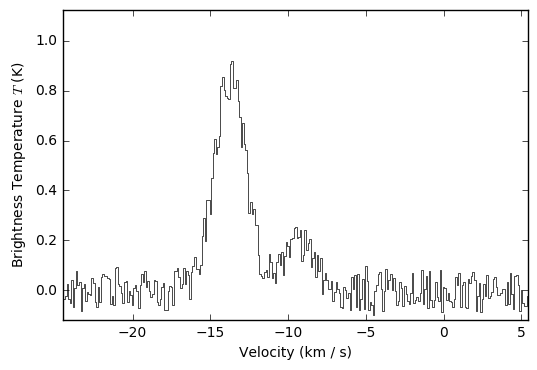

In [4]:
sc.plot_spectrum(3,7)

`multicube` can take minimal and maximal values for spectral model parameters and permute them to generate a **grid in parameter space** with given spacing (`finesse`). This works for an arbirtary number of parameters and with custom resolution for individual parameters (e.g., setting `finesse = [3, 20, 5]` will also work in this case).

(*for Gaussian model in `pyspeckit`, the parameter order is [`amplitude`, `centroid`, `sigma`]*)

In [5]:
sc.update_model('gaussian')
minpars = [0.1, sc.xarr.min().value, 0.1]
maxpars = [2.0, sc.xarr.max().value, 2.0]
finesse = 10
sc.make_guess_grid(minpars, maxpars, finesse)

INFO: Selected gaussian model [multicube.subcube]
INFO: Binning the 3-dimensional parameter space into a (10, 10, 10)-shaped grid [multicube.subcube]


array([[  0.27272727, -21.78181818,   0.27272727],
       [  0.27272727, -21.78181818,   0.44545455],
       [  0.27272727, -21.78181818,   0.61818182],
       ..., 
       [  1.82727273,   2.68181818,   1.48181818],
       [  1.82727273,   2.68181818,   1.65454545],
       [  1.82727273,   2.68181818,   1.82727273]])

This grid, stored under `sc.guess_grid`, can be used to generate a number of spectral models with `pyspeckit`, and the guesses that have the least residual `rms` can be selected for the whole cube:
* `sc.best_map` stored the map between x,y pixel numbers and the numbers of corresponding best models
* `sc.best_model` is the number of the model suited best for the pixel with the highest S/N ratio.

In [6]:
sc.generate_model()
sc.get_snr_map()
sc.best_guess()

INFO: Generating spectral models from the guess grid . . . [multicube.subcube]
INFO: Calculating residuals for generated models . . . [multicube.subcube]
INFO: Overall best model: selected #115 [  0.45 -19.06   1.14] [multicube.subcube]
INFO: Best model @ highest SNR: #529 [ 0.62 -8.19  1.83] [multicube.subcube]


Here's the best model selected for the spectrum above:

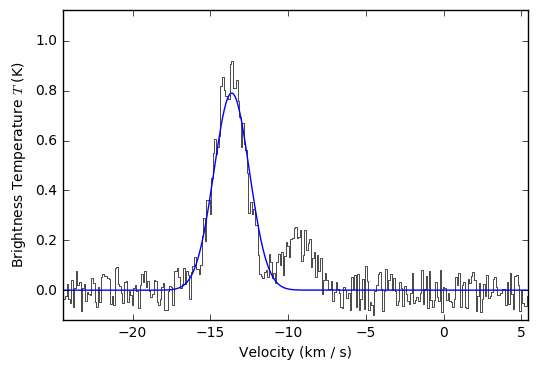

In [7]:
sc.plot_spectrum(3,7)
sc.plotter.axis.plot(sc.xarr.value, sc.model_grid[sc._best_map[3,7]])
# TODO: show the best five guesses or so for this pixel to demonstrate the grid size in the parameter space

### Example #1: fitting the cube with the overall best model:

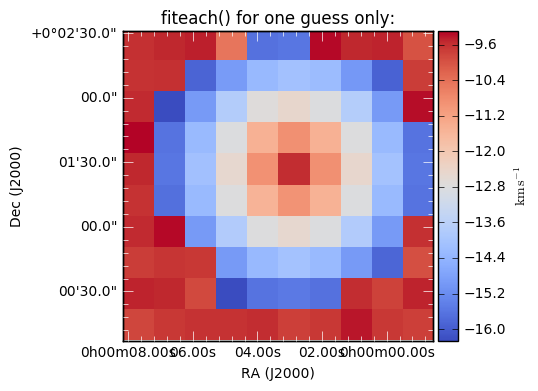

In [8]:
sc1, sc2 = sc, sc.copy()
with io.capture_output() as captured: # suppresses output, normally should not be used
    sc1.fiteach(fittype   = sc1.fittype,
                guesses   = sc1.best_snr_guess, # best for the highest SNR pixel
                multicore = get_ncores(),
                errmap    = sc1._rms_map,
                verbose   = 0,
                **sc1.fiteach_args)

# let's plot the velocity field:
sc1.show_fit_param(1, cmap='coolwarm')
clb = sc1.mapplot.FITSFigure.colorbar
clb.set_axis_label_text(sc1.xarr.unit.to_string('latex_inline'))
sc1.mapplot.FITSFigure.set_title("fiteach() for one guess only:")

Because the same guess was used across the cube with varying velocity centroid, it isn't surprising that the fit failed to converge outside the central spot. Normally, a combination of `start_from_point=(x,y)` and `use_neighbor_as_guess=True` arguments can be passed to `pyspeckit.Cube.fiteach` to gradually spread from (x,y) and avoid divergence in this case, but this approach

* breaks down for large gradients/discontinuities in parameter space
* doesn't work that well when `multicore` is set to a relatively high number.

Alternatively, moment analysis is commonly used get the best initial guess for the nonlinear regression. However, the method is restricted to a singular Gaussian component. In the following code block, an alternative is shown, with initial guesses for each pixel selected as the best generated model for individual spectrum:

### Example #2: fitting the cube best models for each x,y pixel:

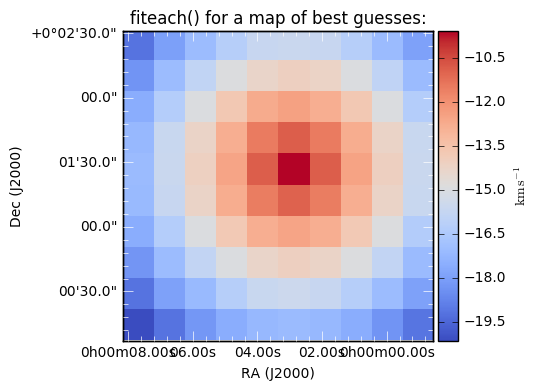

In [9]:
with io.capture_output() as captured: # suppresses output, normally should not be used
    sc2.fiteach(fittype   = sc2.fittype,
                guesses   = sc2.best_guesses, 
                multicore = get_ncores(),
                errmap    = sc2._rms_map,
                verbose   = 0,
                **sc2.fiteach_args);

#sc2.show_fit_param(1, cmap='coolwarm')
sc2.show_fit_param(1, cmap='coolwarm')
clb = sc2.mapplot.FITSFigure.colorbar
clb.set_axis_label_text(sc2.xarr.unit.to_string('latex_inline'))
sc2.mapplot.FITSFigure.set_title("fiteach() for a map of best guesses:")

Voilà! All the pixels are fit.

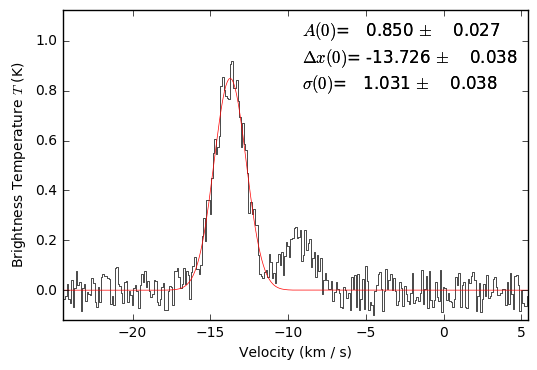

In [10]:
sc.plot_spectrum(3,7, plot_fit=True)